<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Traffic-forecasting/blob/main/Notebooks/part2_predicting_by_residuals_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting by residuals**



<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <img src="https://drive.google.com/uc?export=view&id=1HHzaS7aAGEyrFsbgOxpRufq06dVT5hV8" width="100%">
</body>
</html>


----------------------------------------------------------------------

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <img src="https://drive.google.com/uc?export=view&id=1SS-k3Zfq7dFH9wClblt3uqLjeAFRzqfN" width="100%">
</body>
</html>


# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import style
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout,LSTM,BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks
import os ,datetime,math,time

%matplotlib inline
warnings.filterwarnings('ignore')
#%load_ext tensorboard

2024-07-06 18:11:52.665678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 18:11:52.665818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 18:11:52.836246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Setting on Gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
row = 2

# **Load clean Dataset**

In [ ]:
#!gdown 1Td2yUesbc68Nf1Jq4-DNcGo5gWLbHQiK # Load clean dataset
#!gdown 19_sOEpLtAJFh9fSqYEnuAquR-9SINaFy

#
path1 = '/kaggle/input/traffic-data/clean_traffic_dataframe_with_outliers.csv'
path2 = '/kaggle/input/traffic-data/clean_traffic_dataframe_without_anomalies.csv'
raw_traffic_df = pd.read_csv(path1,index_col =0)
cleaned_traffic_df = pd.read_csv(path2,index_col =0)



print('*'*100)
print('raw_traffic_df are those ones with outliers')
print('cleaned_traffic_df are those ones without outliers')

****************************************************************************************************
raw_traffic_df are those ones with outliers
cleaned_traffic_df are those ones without outliers


In [ ]:
raw_traffic_df

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
index,,,,,,,,,,,,,,,,,,,,,
traffic_0,12.0,12.0,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
traffic_1,12.0,13.0,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
traffic_2,12.0,19.0,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
traffic_3,12.0,23.0,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
traffic_4,12.0,8.0,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traffic_434,15.0,2.0,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
traffic_435,15.0,11.0,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
traffic_436,15.0,9.0,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607


# **Plot graph**

In [ ]:
def plot_graph(dataframe,row,decompose=False,additional_title= 'Orginal'):

  """
  Input: dataframe, a row, decompuse set to True if you want to make the data stationary
  Output: Either mul_decomposition.trend,mul_decomposition.seasonal,mul_decomposition.resid and two plots(orginial and residual) when decompose is True or one plot for data
  """
  plt.style.use('ggplot')
  # Show the plot
  if decompose == True:

      data = dataframe.iloc[row,2:]

      timestamps = dataframe.columns
      timestamps = timestamps[2:]
      src_id = dataframe.iloc[row,0]
      dst_id = dataframe.iloc[row,1]

      mul_decomposition = sm.tsa.seasonal_decompose(data, model = 'multiplicative',period=96,extrapolate_trend='freq') # We used decomposing with method multiplicative and period = 96, since in a day we have 24 h * 4 quarter = 96
      trend = mul_decomposition.trend
      seasonal = mul_decomposition.seasonal
      residual = mul_decomposition.resid

      fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))
      positions = range(0, len(data), 100) # Define the positions for x-ticks (e.g., every 50th point)
      labels = [timestamps[i] for i in positions]       # Define the corresponding labels for these positions


      # Plot original

      axes[0].plot(data, label=f'Original Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}', color='blue')
      axes[0].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[0].set_xticks([])

      axes[0].legend()

      # Plot trend
      axes[1].plot(trend, label='Trend', color='blue')
      axes[1].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[1].set_xticks([])
      axes[1].legend()

      # Plot seasonal
      axes[2].plot(seasonal, label='Seasonal', color='blue')
      axes[2].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[2].set_xticks([])

      axes[2].legend()

      # Plot residual
      axes[3].plot(residual, label='Residual', color='blue')
      axes[3].grid(True, color='brown', linestyle='--', alpha=0.5)

      axes[3].set_xticks(positions)
      axes[3].set_xticklabels(labels, rotation=90)
      axes[3].legend()

      plt.tight_layout()
      plt.show()
      fig.savefig(f'Decomposed plot of traffic_{row}.png',dpi=300)
      return mul_decomposition.trend,mul_decomposition.seasonal,mul_decomposition.resid


  else:
      plt.style.use('ggplot')
      fig, ax = plt.subplots(figsize=(12, 4))

      data = dataframe.iloc[row,2:]

      timestamps = dataframe.columns
      timestamps = timestamps[2:]
      src_id = dataframe.iloc[row,0]
      dst_id = dataframe.iloc[row,1]

      data.plot(label=f'{additional_title} Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}',color='blue')
      plt.grid(True, color='brown', linestyle='--', alpha=0.5)


      # Define the positions for x-ticks (e.g., every 50th point)
      positions = range(0, len(data), 100)
      # Define the corresponding labels for these positions

      labels = [timestamps[i] for i in positions]

      # Set the positions and labels of the x-ticks
      ax.set_xticks(positions)
      ax.set_xticklabels(labels, rotation=90)  # Rotation to vertical
      plt.legend()
      plt.show()
      fig.savefig(f'Original plot of traffic_{row}.png',dpi=300)



# **Step One: Make timeseries Stationarity**
Stationarity is one of the most important properties of time series.But what does it mean for data to be stationary?

If a time series is **stationary**, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called homoscedasticity). Also, it should not contain seasonality.

We can then summarize the 3 main characteristics as follows:


**1_Constant mean**


**2_Constant variance**


**3_No seasonality**






## a) Check stationary by  **ADF** and **KPSS**

In [ ]:
def check_stationary_print(dataframe,row, second_stationary_checking=False):

  """ Input: dataframe , row which shows each traffic and second_stationary_checking which tells you are checking a timeseries for a second time after converting it to stationary or not
      Output: _ (Just show result from two mentioned tests.)
      This function receive a row of dataframe and check weather it is stationary or not by ADF and KPSS tests.
  """

  if second_stationary_checking == False:
    X = dataframe.iloc[row,2:] # Get data of the sepecified row. 2 here means we don't want src_id and dst_id
  else:
    X =dataframe.iloc[row]
  threshold = 0.05 # This the threshold for checking p_value

  #ADF TEST#
  ##############################################################################
  print('*'*100)
  adfuller_result = adfuller(X)
  print('ADF Statistic: %f' % adfuller_result[0])
  if adfuller_result[1] <= threshold:

    print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Stationary***')

  else:
    print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Non-Stationary***')

  print('Critical Values:')
  for key, value in adfuller_result[4].items():
      print('\t%s: %.3f' % (key, value))


  #KPSS TEST#
  ##############################################################################
  print('*'*100)
  kpss_result = kpss(X)
  print('KPSS Statistic: %f' % kpss_result[0])
  if kpss_result[1] <= threshold:

    print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Stationary***')

  else:
    print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Non-Stationary***')

  print('Critical Values:')
  for key, value in kpss_result[3].items():
      print('\t%s: %.3f' % (key, value))


In [ ]:
# Call function
################################################################################
# Here we just check being stationary for two timeseries(traffics).

print(f'Checking stationary for traffic {row}')
check_stationary_print(dataframe=raw_traffic_df,row=row,second_stationary_checking=False)
print('\n\n\n')


Checking stationary for traffic 2
****************************************************************************************************
ADF Statistic: -7.699552
p-value: 0.000000 			 ***ADF says this time series is Stationary***
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
****************************************************************************************************
KPSS Statistic: 0.177601
p-value: 0.100000 			 ***KPSS says this time series is Non-Stationary***
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739






In [ ]:
def check_stationary_for_all_data(dataframe,title=None):
  """ Input: dataframe includin all traffic
      Output: Stationary_dataframe which shows weather the timeseries is stationary or not
      This function checks being stationary or not for all rows of dataframe and return a stationary dataframe telling which one is stationary.
  """

  threshold = 0.05 # This the threshold for checking p_value
  number_of_rows =  dataframe.shape[0]
  stationary_list = list()
  adfuller_result_list = list()
  kpss_result_list = list()

  for row in tqdm(range(number_of_rows),f"Program is checking stationary of all {title} traffics. Please wait"):

    X = dataframe.iloc[row,2:]
    adfuller_result = adfuller(X)
    kpss_result = kpss(X)
    if adfuller_result[1] <= threshold:
       adfuller_result_list.append(1)  # 1 means Stationary and 0 mean Non-Stationary
    else:
      adfuller_result_list.append(0)

    if kpss_result[1] <= threshold:
       kpss_result_list.append(1)
    else:
      kpss_result_list.append(0)


    if adfuller_result[1] <= threshold and kpss_result[1] <= threshold:
      stationary_list.append(1)
    else:
      stationary_list.append(0)


  # Store 1 denoted for stationary  and 0 for non_stationary for each row(traffic) in a dataframe
  # We call a timeseries stationary if in both tests it is stationary, meaning both test must show 1 as thier results
  stationary_dataframe = pd.DataFrame()
  stationary_dataframe.insert(loc=0,column="src_id",value=dataframe['src_id'])
  stationary_dataframe.insert(loc=1,column="dst_id",value=dataframe['dst_id'])
  stationary_dataframe.insert(loc=2,column="ADF_test",value=adfuller_result_list)
  stationary_dataframe.insert(loc=3,column="KPSS_test",value=kpss_result_list)
  stationary_dataframe.insert(loc=4,column='Stationary_status',value=stationary_list)

  return stationary_dataframe


In [ ]:
# Call function
###########################################################################
stationary_df_with_outliers = check_stationary_for_all_data(dataframe = raw_traffic_df,title = 'raw')
stationary_df_without_outliers  = check_stationary_for_all_data(dataframe = cleaned_traffic_df,title ='cleaned')
stationary_df_with_outliers.to_csv('stationary_df_with_outliers.csv',index=True)
stationary_df_without_outliers.to_csv('stationary_df_without_outliers.csv',index = True)

Program is checking stationary of all raw traffics. Please wait: 100%|██████████| 439/439 [00:57<00:00,  7.60it/s]
Program is checking stationary of all cleaned traffics. Please wait: 100%|██████████| 439/439 [00:58<00:00,  7.51it/s]


In [ ]:
print("The following dataframe is called stationary dataframe which says which traffic is stationary and which is not.")
print("1 denoted as Stationary and 0 denoted as Non-Stationary")
number_of_both_states = np.unique(stationary_df_with_outliers['Stationary_status'],return_counts=True)
print("We call a timeseries Stationary if both tests(ADF, KPSS) verify its Stationary, meaning that both tests must show 1 as thier results\n")
print("Based on this dataframe, there are:")
print(f"{number_of_both_states[1][1]} Stationary timeseris and {number_of_both_states[1][0]} Non-Stationary timeseris")
stationary_df_with_outliers

The following dataframe is called stationary dataframe which says which traffic is stationary and which is not.
1 denoted as Stationary and 0 denoted as Non-Stationary
We call a timeseries Stationary if both tests(ADF, KPSS) verify its Stationary, meaning that both tests must show 1 as thier results

Based on this dataframe, there are:
163 Stationary timeseris and 276 Non-Stationary timeseris


,src_id,dst_id,ADF_test,KPSS_test,Stationary_status
index,,,,,
traffic_0,12.0,12.0,1,0,0
traffic_1,12.0,13.0,1,1,1
traffic_2,12.0,19.0,1,0,0
traffic_3,12.0,23.0,1,0,0
traffic_4,12.0,8.0,1,0,0
...,...,...,...,...,...
traffic_434,15.0,2.0,1,0,0
traffic_435,15.0,11.0,1,0,0
traffic_436,15.0,9.0,1,0,0


In [ ]:
non_stationary_traffic_indexes = stationary_df_with_outliers[stationary_df_with_outliers['Stationary_status']==0].index
print('The following indexes are for non_stationary traffics.')
non_stationary_traffic_indexes

The following indexes are for non_stationary traffics.


Index(['traffic_0', 'traffic_2', 'traffic_3', 'traffic_4', 'traffic_5',
       'traffic_6', 'traffic_7', 'traffic_8', 'traffic_9', 'traffic_11',
       ...
       'traffic_424', 'traffic_426', 'traffic_427', 'traffic_428',
       'traffic_430', 'traffic_431', 'traffic_434', 'traffic_435',
       'traffic_436', 'traffic_437'],
      dtype='object', name='index', length=276)

## b) Make Stationary by decompositions

### b_1) Making one traffic stationary and see result

Here we make row(traffic)_2 Stationary by deccomposing method.
You can see 4 plots in the follwoing, obtained by decomposing model


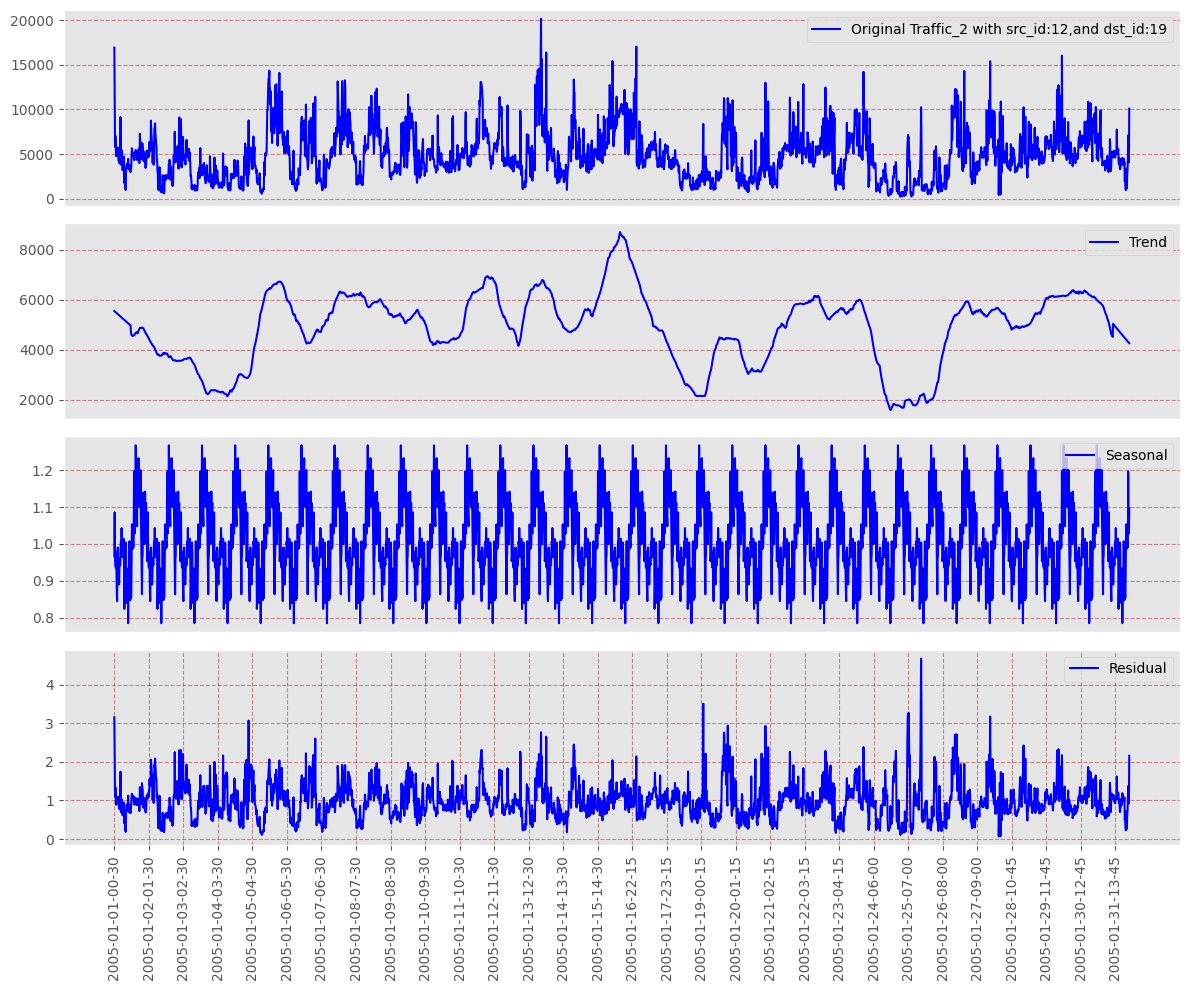

****************************************************************************************************
ADF Statistic: -11.495558
p-value: 0.000000 			 ***ADF says this time series is Stationary***
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
****************************************************************************************************
KPSS Statistic: 0.006585
p-value: 0.100000 			 ***KPSS says this time series is Stationary***
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
********************************************************************************************************************************************************************************************************
Great. This traffic now is Stationary
********************************************************************************************************************************************************************************************************


In [ ]:
# Since additive is not useful as much as multiplicative.



print(f'Here we make row(traffic)_{row} Stationary by deccomposing method.')
print('You can see 4 plots in the follwoing, obtained by decomposing model')
mul_decomposition_trend,mul_decomposition_seasonal,mul_decomposition_resid = plot_graph(cleaned_traffic_df,row,decompose=True)

# Check statistical tests for this traffic


#ADF TEST#
##############################################################################
threshold = 0.1
X = mul_decomposition_resid.dropna() # drop nan values. Since after decomposing we have several Nan Values at the begining and in the end.
print('*'*100)
adfuller_result = adfuller(X)
print('ADF Statistic: %f' % adfuller_result[0])
if adfuller_result[1] <= threshold:

  print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Stationary***')

else:
  print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Non-Stationary***')

print('Critical Values:')
for key, value in adfuller_result[4].items():
    print('\t%s: %.3f' % (key, value))


#KPSS TEST#
##############################################################################
print('*'*100)
kpss_result = kpss(X)
print('KPSS Statistic: %f' % kpss_result[0])
if kpss_result[1] <= threshold:

  print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Stationary***')

else:
  print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Non-Stationary***')

print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))


print('*'*200)
print('Great. This traffic now is Stationary')
print('*'*200)

### b_2) Making all traffics stationary

In [ ]:
# do the same for all dataframe to make them stationary
def make_all_stationary(traffic_df,title=None):

  for index in tqdm(range(traffic_df.shape[0]), f"We are making all traffic stationary {title}. Please wait: "): # Itereate over all data and make them stationary

    data = traffic_df.iloc[index,2:]

    mul_decomposition = sm.tsa.seasonal_decompose(data, model = 'multiplicative',period=96,extrapolate_trend='freq'
                                                  )
    trend = mul_decomposition.trend.dropna()
    seasonal = mul_decomposition.seasonal.dropna()
    residual = mul_decomposition.resid.dropna()
    names =  residual.index

    if index == 0:
      seasonal_dataframe = pd.DataFrame(columns =residual.index )
      trend_dataframe = pd.DataFrame(columns =residual.index )
      residual_dataframe = pd.DataFrame(columns =residual.index )

      trend_dataframe.loc[len(trend_dataframe)] = trend
      seasonal_dataframe.loc[len(seasonal_dataframe)] = seasonal
      residual_dataframe.loc[len(residual_dataframe)] = residual

    else:

      trend_dataframe.loc[len(trend_dataframe)] = trend
      seasonal_dataframe.loc[len(seasonal_dataframe)] = seasonal
      residual_dataframe.loc[len(residual_dataframe)] = residual

  #Store residuals, trends and seasonalities for all data into three dataframes
  trend_dataframe.insert(loc=0,column='src_id',value=traffic_df['src_id'].values)
  trend_dataframe.insert(loc=1,column='dst_id',value=traffic_df['dst_id'].values)

  seasonal_dataframe.insert(loc=0,column='src_id',value=traffic_df['src_id'].values)
  seasonal_dataframe.insert(loc=1,column='dst_id',value=traffic_df['dst_id'].values)

  residual_dataframe.insert(loc=0,column='src_id',value=traffic_df['src_id'].values)
  residual_dataframe.insert(loc=1,column='dst_id',value=traffic_df['dst_id'].values)


  print("'\nAfter this computation, we have three dataframes of residual traffics, trend traffic and seasonality traffic, obtained by decomposition method")
  trend_dataframe.to_csv(f'trend_dataframe_{title}.csv',index=False)
  seasonal_dataframe.to_csv(f'seasonal_dataframe_{title}.csv',index = False)
  residual_dataframe.to_csv(f'residual_dataframe_{title}.csv',index= False)
  return trend_dataframe, seasonal_dataframe, residual_dataframe



In [ ]:
trend_dataframe_with_outliers, seasonal_dataframe_with_outliers, residual_dataframe_with_outliers = make_all_stationary(raw_traffic_df,title='with_outliers')
print('*'*200)
print('*'*200)
print('*'*200)
trend_dataframe_without_outliers, seasonal_dataframe_without_outliers, residual_dataframe_without_outliers = make_all_stationary(cleaned_traffic_df,title='without_outliers')

We are making all traffic stationary with_outliers. Please wait: 100%|██████████| 439/439 [00:07<00:00, 60.91it/s]


'
After this computation, we have three dataframes of residual traffics, trend traffic and seasonality traffic, obtained by decomposition method
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************


We are making all traffic stationary without_outliers. Please wait: 100%|██████████| 439/439 [00:07<00:00, 60.14it/s]


'
After this computation, we have three dataframes of residual traffics, trend traffic and seasonality traffic, obtained by decomposition method


# **Step two: Run our models**

## a) Define  Callbacks
to have better control on traing part

In [ ]:
def checkpoint(path,metrics='val_loss',save_weights_only=False):

    root_folder = 'Checkpint_Folder'
    filename = 'cp.keras'
    # Join them to create the full path
    full_path = os.path.join(root_folder,path, filename)
    checkpoint_path = full_path
    checkpoint_dir =os.path.dirname(full_path)
    check =callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                          monitor=metrics,
                                          verbose=1,
                                          save_weights_only = save_weights_only,
                                          save_best_only=True,
                                          mode='auto',
                                          save_freq ='epoch')

    return check
#############################################
def early_stopping(metrics='val_loss'):

    early = callbacks.EarlyStopping(monitor=metrics,
                                                  min_delta=.02,
                                                  patience=8,
                                                  verbose=1,
                                                  mode="auto")

    return early

#############################################
def tensor_board(path):

    logdir = os.path.join("TensorBoardlogs_Folder",path, datetime.datetime.now().strftime("%Y%m%d-%H%M"))
    tensor = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    return tensor

## b) Define Hyperparameters

In [ ]:
Epochs = 200
Batch_size = 8
window_size = 20
period = 96
split_train_test_portion = 0.1
validation_portion = 0.1 # Allocate 10 % of train_data to validation

## c) Split dataset to train and test part

In [ ]:
def split_train_test(split_train_test_portion, residual_dataframe,normalization=False):
  res_df = residual_dataframe.copy()   # Forcast by residuals not Originals
  res_df.drop(['src_id','dst_id'],axis=1,inplace=True) # Remove src and dst as we don't need them now


  item = int(residual_dataframe.shape[1] * split_train_test_portion)
  # Since we need to work on residuals, we have
  train_part_dataframe = res_df.iloc[:,:-item] # Choose 2700 timestamps for training
  test_part_dataframe = res_df.iloc[:,-item:]  # Choose the rest timestamps for testing
  print('train_part_dataframe.shape: ',train_part_dataframe.shape)
  print('test_part_dataframe.shape: ',test_part_dataframe.shape)


  if normalization ==True:
    train_names = train_part_dataframe.columns
    test_names = test_part_dataframe.columns
    scaler = MinMaxScaler(feature_range=(0, 1)) #F: The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data

    train_part_dataframe = scaler.fit_transform(train_part_dataframe.T)
    train_part_dataframe = pd.DataFrame(train_part_dataframe.T)
    train_part_dataframe.columns = train_names


    test_part_dataframe = scaler.transform(test_part_dataframe.T)
    test_part_dataframe = pd.DataFrame(test_part_dataframe.T)
    test_part_dataframe.columns = test_names
  #test_part_dataframe = scaler.transform(test_part_dataframe)


  return train_part_dataframe, test_part_dataframe

In [ ]:
print('We split the residual_dataframe into two bellow parts:')
print('*'*100)
print('For raw_traffic_df:')
train_part_dataframe_with_outliers, test_part_dataframe_with_outliers = split_train_test(split_train_test_portion=split_train_test_portion,residual_dataframe=residual_dataframe_with_outliers)


We split the residual_dataframe into two bellow parts:
****************************************************************************************************
For raw_traffic_df:
train_part_dataframe.shape:  (439, 2647)
test_part_dataframe.shape:  (439, 294)


## d) Prepare X_train, y_train

In [ ]:
def create_sequences(train_part_dataframe,test_part_dataframe,row, window_size):
    """
    Input: dataframe, row, windows_size, prediction_size
    Output: X_train, y_train
    This function tries to prepare X_train and y_train
    """

    # For training part
    ####################################################
    train_row = train_part_dataframe.iloc[row,:].copy()
    train_row = np.reshape(train_row, (-1,1))
    X_train = list()
    y_train = list()



    for i in range(window_size, len(train_row)):
        X_train.append(train_row[i-window_size:i, 0])
        y_train.append(train_row[i, 0])




    # Turn to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    # Reshaping to be appropriate for models
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = np.reshape(y_train, (y_train.shape[0],1))


    # For testing part
    ####################################################
    test_row = test_part_dataframe.iloc[row,:].copy()
    test_row = np.reshape(test_row, (-1,1))
    X_test = list()
    y_test = list()



    for i in range(window_size, len(test_row)):
      X_test.append(test_row[i-window_size:i, 0])
      y_test.append(test_row[i, 0])


    # Turn to numpy array
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    # Reshaping to be appropriate for models
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))

    return  X_train, y_train,X_test,y_test


In [ ]:
# Call function
X_train_with_outliers, y_train_with_outliers,X_test_with_outliers, y_test_with_outliers = create_sequences(train_part_dataframe=train_part_dataframe_with_outliers,test_part_dataframe=test_part_dataframe_with_outliers,row=row, window_size=window_size)
print(f'These information are for traffic {row} with outliers')
print('*'*100)
print('X_train.shape: ',X_train_with_outliers.shape)
print('Y_train.shape: ',y_train_with_outliers.shape)
print('X_test.shape: ',X_test_with_outliers.shape)
print('Y_test.shape: ',y_test_with_outliers.shape)




These information are for traffic 2 with outliers
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)


## e) Model 1: Local RNN

### e_1) Define model

In [ ]:
def RNN(input_shape):

	# initializing the RNN
	rnn = Sequential()

	# adding RNN layers and dropout regularization
	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True,
							input_shape = input_shape))
	rnn.add(Dropout(0.2))

	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True))

	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True))

	rnn.add( SimpleRNN(units = 50))

	# adding the output layer
	rnn.add(Dense(units = 1))

	# compiling RNN
	rnn.compile(optimizer = 'adam',
												loss = 'mean_squared_error'
												)



	return rnn
#%tensorboard --logdir TensorBoardlogs_Folder/ "--load_fast=false"

### e_2) Train Model

In [ ]:
# Set callbacks
print(f'This is training for traffic_{row} with outliers')
print('*'*100)

path = f"/kaggle/working/RNN_on_residuals_for_traffic_{row}_with_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

# Call model
input_shape = (window_size,1)
rnn_with_outliers = RNN(input_shape)
rnn_with_outliers.summary()

# fitting the model
start = time.time()
rnn_with_outliers.fit(X_train_with_outliers, y_train_with_outliers, epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)

This is training for traffic_2 with outliers
****************************************************************************************************


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
  5/296 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4517 

I0000 00:00:1720289692.391551      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1934
Epoch 1: val_loss improved from inf to 0.14834, saving model to /kaggle/working/RNN_on_residuals_for_traffic_2_with_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 0.1933 - val_loss: 0.1483
Epoch 2/200
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1394
Epoch 2: val_loss improved from 0.14834 to 0.14512, saving model to /kaggle/working/RNN_on_residuals_for_traffic_2_with_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1394 - val_loss: 0.1451
Epoch 3/200
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1341
Epoch 3: val_loss did not improve from 0.14512
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1340 - val_loss: 0.1653
Epoch 4/200
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1413
Epoch 4: val_loss improved from 0.14512 to 0.14488, saving model to /kaggle/working/RNN_on_residuals_for_traffic_2_with_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1411

### e_3) Result

In [ ]:
def performance(model_name,prediction_type, operations_on_input, row, y_true, y_pred,training_time):
    global raw_traffic_df


    # Extract relevant ids from clean_df
    src_id = raw_traffic_df.iloc[row, 0]
    dst_id = raw_traffic_df.iloc[row, 1]
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    # Calculate metrics
    mean_squared_error = mse(y_true=y_true, y_pred=y_pred)
    mean_absolute_error = mae(y_true=y_true, y_pred=y_pred)
    mean_absolute_percentage_error = mape(y_true=y_true, y_pred=y_pred)

    # Create a new row of result
    performance_df = pd.DataFrame({
        "Traffic_id":[row],
        "Src_id": [src_id],
        "Dst_id": [dst_id],
        "Model": [model_name],
        "Prediction_type":[prediction_type],
        "Input":[operations_on_input],
        "Training_time[s]": [training_time],
        "MAE": [mean_absolute_error],
        "MSE": [mean_squared_error],
        "MAPE": [mean_absolute_percentage_error],
    })

    # Append the new row to the existing performance_df


    return performance_df

In [ ]:
# Prediction and performance on dataset with outliers
y_test_pred_with_outliers = rnn_with_outliers.predict(X_test_with_outliers)


rnn_perforamnce_with_outliers = performance(model_name='Model_1: RNN',
                                            prediction_type='Prediction_on_residual',
                                            operations_on_input="with_outliers",
                                            row = row,
                                            y_true=y_test_with_outliers,
                                            y_pred=y_test_pred_with_outliers,
                                            training_time =training_time )

display(rnn_perforamnce_with_outliers)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_1: RNN,Prediction_on_residual,with_outliers,37.0,0.202944,0.07644,0.216851


### e_4) Effect of removing outliers

In [ ]:
# Call section c) Split dataset to train and test without ouliers
print('For cleaned_traffic_df')
print('*'*100)
train_part_dataframe_without_outliers, test_part_dataframe_without_outliers = split_train_test(split_train_test_portion=split_train_test_portion,residual_dataframe=residual_dataframe_without_outliers)

# Call section d) Prepare X_train and y_train

X_train_without_outliers, y_train_without_outliers,X_test_without_outliers, y_test_without_outliers = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers,
                                                                                                                       row=row, window_size=window_size)
print(f'\n\nThese information are for traffic {row} without_outliers.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers.shape)
print('Y_train.shape: ',y_train_without_outliers.shape)
print('X_test.shape: ',X_test_without_outliers.shape)
print('Y_test.shape: ',y_test_without_outliers.shape)


# Call section e_2) Train model
print(f'This is training for traffic_{row} without outliers')
print('*'*100)
path = f"RNN_on_residuals_for_row{row} without outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

input_shape = (window_size,1)
rnn_without_outliers = RNN(input_shape)
rnn_without_outliers.summary()
start = time.time()
rnn_without_outliers.fit(X_train_without_outliers, y_train_without_outliers, epochs=Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)


For cleaned_traffic_df
****************************************************************************************************
train_part_dataframe.shape:  (439, 2647)
test_part_dataframe.shape:  (439, 294)


These information are for traffic 2 without_outliers.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_2 without outliers
****************************************************************************************************


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2171
Epoch 1: val_loss improved from inf to 0.14838, saving model to Checkpint_Folder/RNN_on_residuals_for_row2 without outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.2169 - val_loss: 0.1484
Epoch 2/200
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1219
Epoch 2: val_loss did not improve from 0.14838
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1218 - val_loss: 0.1917
Epoch 3/200
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1054
Epoch 3: val_loss improved from 0.14838 to 0.13804, saving model to Checkpint_Folder/RNN_on_residuals_for_row2 without outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1055 - val_loss: 0.1380
Epoch 4/200
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1128
Epoch 4: val_loss did not improve from 0.13804
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1128 - val_loss: 0.1397
Epoch 5/200
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

In [ ]:
# Call e_3) Result
y_test_pred_without_outliers = rnn_without_outliers.predict(X_test_without_outliers)
rnn_perforamnce_without_outliers = performance(model_name='Model_1: Rnn',prediction_type='Prediction_on_residual',operations_on_input="without_outliers",row = row,
                                            y_true=y_test_without_outliers,
                                            y_pred=y_test_pred_without_outliers,
                                            training_time = training_time)

rnn_perforamnce_without_outliers = pd.concat([rnn_perforamnce_with_outliers,rnn_perforamnce_without_outliers],axis =0)
rnn_perforamnce_without_outliers.reset_index(inplace=True)
rnn_perforamnce_without_outliers.drop(['index'],axis= 1,inplace=True)
display(rnn_perforamnce_without_outliers)



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_1: RNN,Prediction_on_residual,with_outliers,37.0,0.202944,0.076440,0.216851
1,2,12.0,19.0,Model_1: Rnn,Prediction_on_residual,without_outliers,34.0,0.209664,0.073936,0.232761


### d_7) Effect of Normalizing

In [ ]:

# Call section c)Split datsaset to train and test with normalization=True
train_part_dataframe_without_outliers_normalized, test_part_dataframe_without_outliers_normalized = split_train_test(split_train_test_portion=split_train_test_portion,
                                                                                               residual_dataframe=residual_dataframe_without_outliers,
                                                                                               normalization=True)
# Call section d) Prepare X_train, y_train
X_train_without_outliers_normalized, y_train_without_outliers_normalized,X_test_without_outliers_normalized, y_test_without_outliers_normalized = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers_normalized,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers_normalized,
                                                                                                                       row=row, window_size=window_size)
print(f'\n\nThese information are for traffic {row} without_outliers with noramlization.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers_normalized.shape)
print('Y_train.shape: ',y_train_without_outliers_normalized.shape)
print('X_test.shape: ',X_test_without_outliers_normalized.shape)
print('Y_test.shape: ',y_test_without_outliers_normalized.shape)

# Call section e_2) Train model

print(f'This is training for traffic_{row} without outliers')
print('*'*100)
path = f"RNN_on_residuals_for_row{row} without outliers with normalization"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]


rnn_without_outliers_normalized = RNN(input_shape)
rnn_without_outliers_normalized.summary()
start = time.time()
rnn_without_outliers_normalized.fit(X_train_without_outliers_normalized, y_train_without_outliers_normalized, epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)



train_part_dataframe.shape:  (439, 2647)
test_part_dataframe.shape:  (439, 294)


These information are for traffic 2 without_outliers with noramlization.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_2 without outliers
****************************************************************************************************


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1258
Epoch 1: val_loss improved from inf to 0.00993, saving model to Checkpint_Folder/RNN_on_residuals_for_row2 without outliers with normalization/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.1255 - val_loss: 0.0099
Epoch 2/200
292/296 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100
Epoch 2: val_loss improved from 0.00993 to 0.00987, saving model to Checkpint_Folder/RNN_on_residuals_for_row2 without outliers with normalization/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 3/200
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 3: val_loss improved from 0.00987 to 0.00820, saving model to Checkpint_Folder/RNN_on_residuals_for_row2 without outliers with normalization/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 4/200
294/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 4: val_loss improved from 0.00

In [ ]:
# Call section e_3) Result
y_test_pred_without_outliers_normalized = rnn_without_outliers_normalized.predict(X_test_without_outliers_normalized)
rnn_perforamnce_without_outliers_normalized = performance(model_name='Model_1: Rnn',
                                               prediction_type='Prediction_on_residual',
                                               operations_on_input="normalized_without_outliers",row = row,
                                               y_true=y_test_without_outliers_normalized,
                                               y_pred=y_test_pred_without_outliers_normalized,training_time=training_time )

rnn_perforamnce_without_outliers_normalized = pd.concat([rnn_perforamnce_without_outliers,rnn_perforamnce_without_outliers_normalized],axis =0)
rnn_perforamnce_without_outliers_normalized.reset_index(inplace=True)
rnn_perforamnce_without_outliers_normalized.drop(['index'],axis= 1,inplace=True)
display(rnn_perforamnce_without_outliers_normalized)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_1: RNN,Prediction_on_residual,with_outliers,37.0,0.202944,0.076440,0.216851
1,2,12.0,19.0,Model_1: Rnn,Prediction_on_residual,without_outliers,34.0,0.209664,0.073936,0.232761
2,2,12.0,19.0,Model_1: Rnn,Prediction_on_residual,normalized_without_outliers,35.0,0.040526,0.003486,0.195460


In [ ]:
rnn_perforamnce_without_outliers_normalized.to_csv('Performance_of_rnn_by_residuals.csv',index=True)

### d_6) Plot best prediction

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


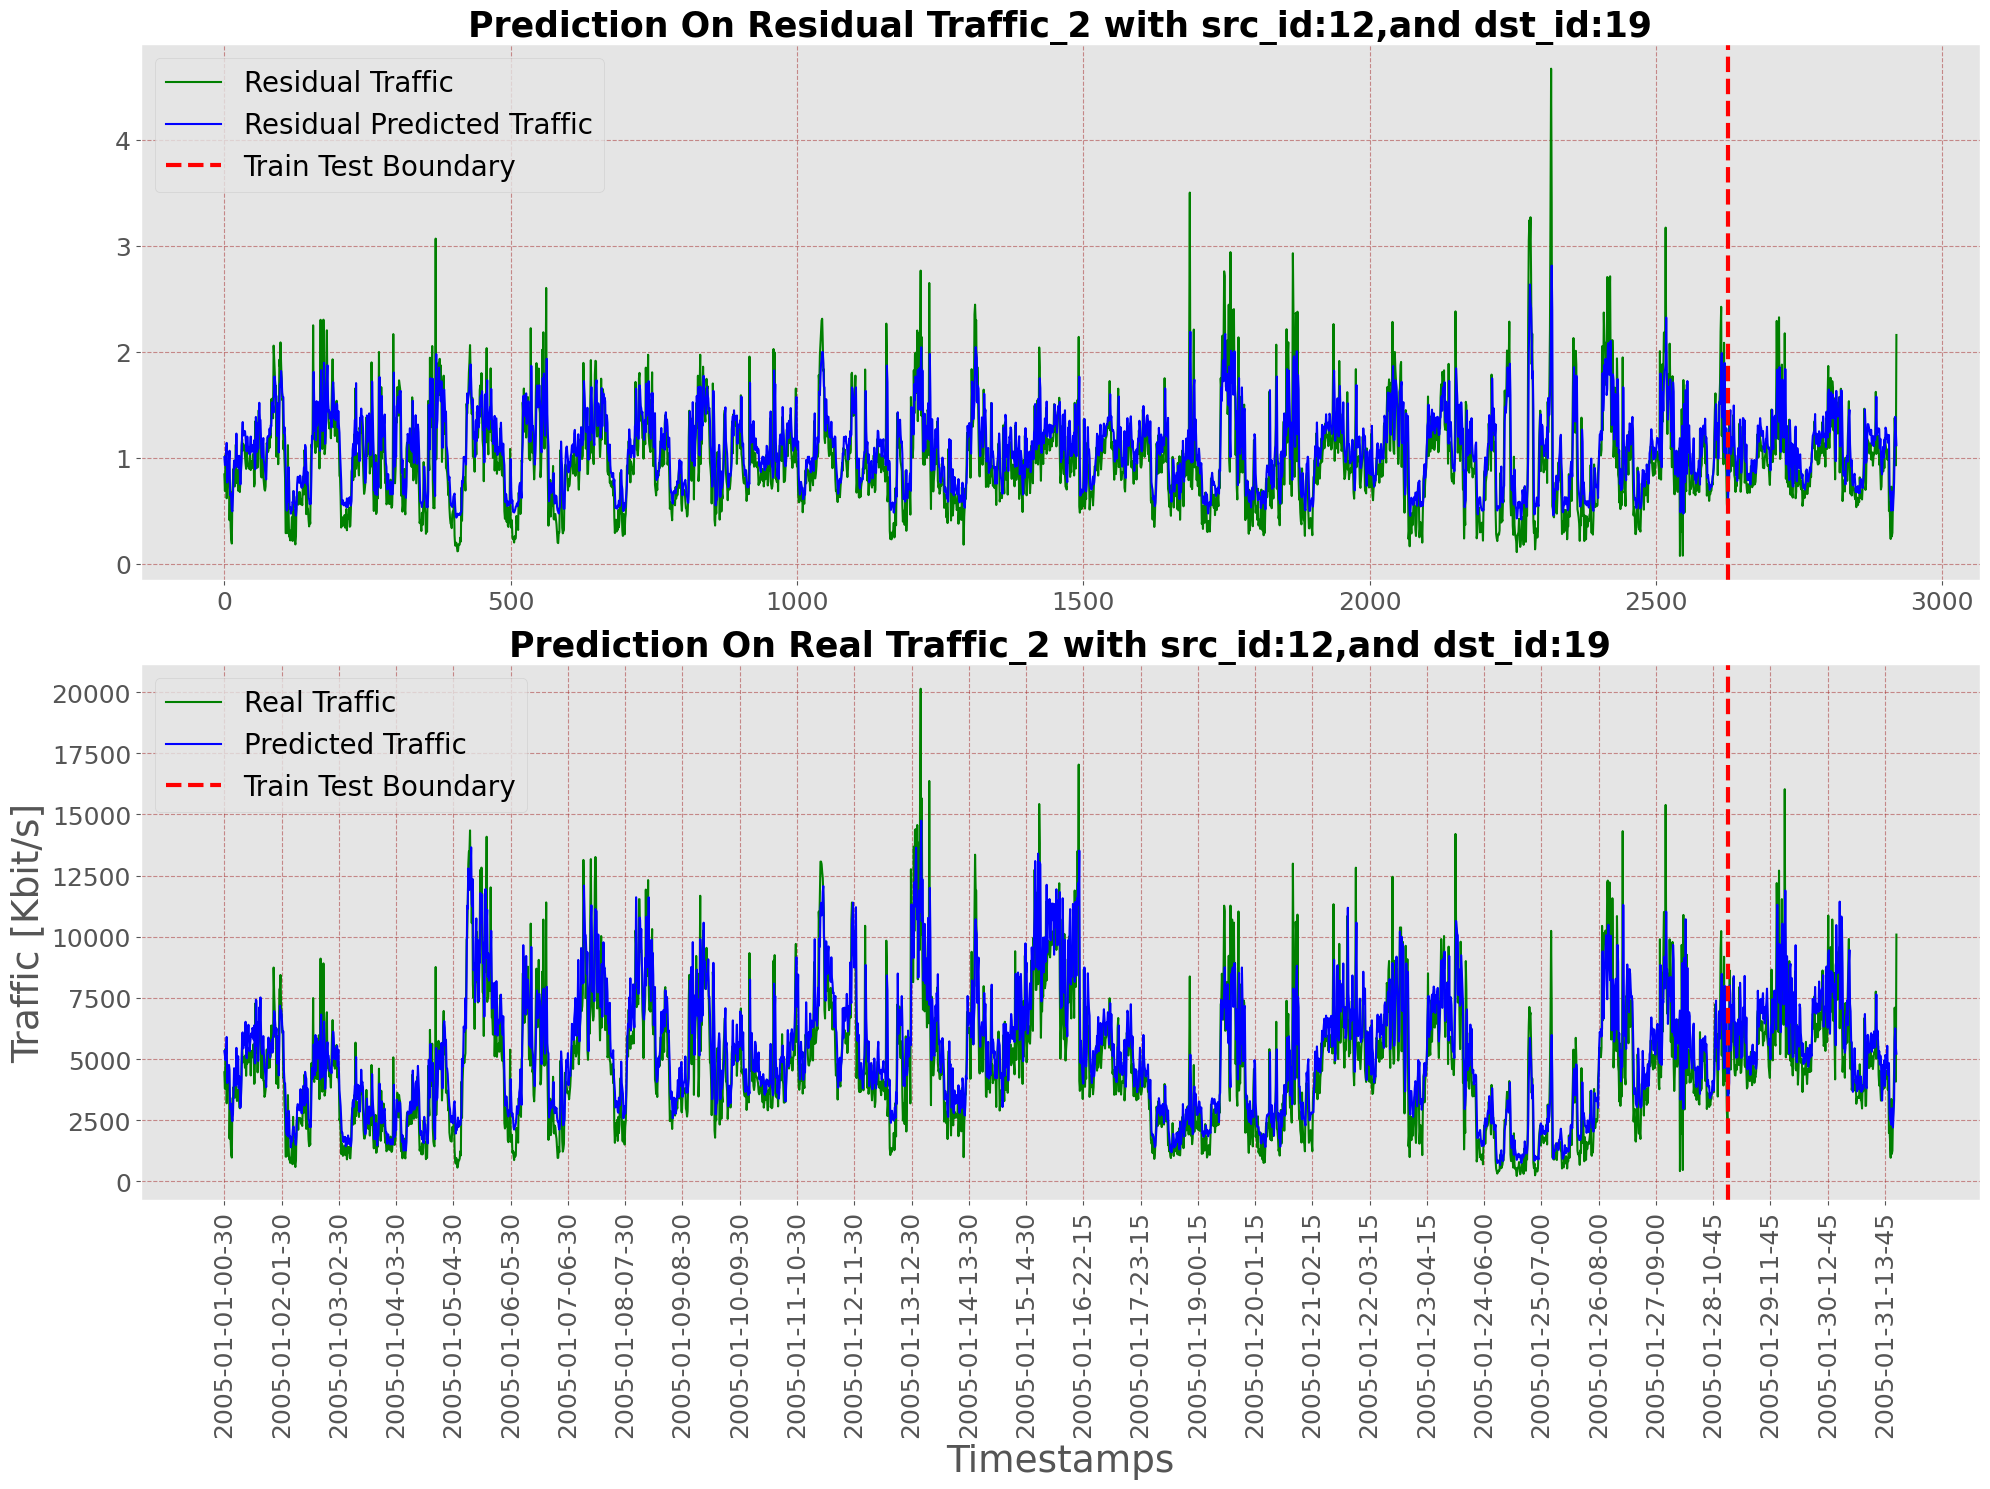

In [ ]:
def plot_results(models_list, residual_list,seasonal_list, trend_list, train_part_list, test_part_list,cleaned_traffic_df,index,title):
        # Set values
        ################################################################
        model = models_list[index]
        residual_df = residual_list[index]
        seasonal_df = seasonal_list[index]
        trend_df = trend_list[index]

        train_df = train_part_list [index]
        test_df = test_part_list [index]


        src_id = residual_df.iloc[row,0]
        dst_id = residual_df.iloc[row,1]
        train_part = train_df.iloc[row,20:]
        test_part = test_df.iloc[row,:]



        # Prepare again all data
        ################################################################
        all_data = residual_df.iloc[row,2:]
        train_row = np.reshape(all_data, (-1,1))
        X_all_true = list()
        y_all_true = list()

        for i in range(window_size, len(train_row)):
          X_all_true.append(train_row[i-window_size:i, 0])
          y_all_true.append(train_row[i, 0])


        # Turn to numpy array
        X_all_true = np.array(X_all_true)
        y_all_true = np.array(y_all_true)
        # Reshaping to be appropriate for models
        X_all_true = np.reshape(X_all_true, (X_all_true.shape[0], X_all_true.shape[1],1))
        y_all_true = np.reshape(y_all_true, (y_all_true.shape[0],1))




        #Predict
        ################################################################
        y_all_pred = model.predict(X_all_true)
        y_all_pred = np.squeeze(y_all_pred)


        data1 = residual_df.iloc[row,2:]
        timestamps1 = residual_df.columns
        timestamps1 = timestamps1[2:]
        positions1 = range(0, len(data1), 100) # Define the positions for x-ticks (e.g., every 50th point)
        labels1 = [timestamps1[i] for i in positions1]       # Define the corresponding labels for these positions



        # Generate the plots
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

        # Plot 1: Residual traffic prediction
        ax1.plot(np.arange(len(train_part)), train_part, label='Residual Traffic', color='g')
        ax1.plot(len(train_part) + np.arange(len(test_part)), test_part, color='g')
        ax1.plot(np.arange(len(y_all_pred)), y_all_pred, label='Residual Predicted Traffic', color='b')

        vline_position = np.arange(len(train_part))[-1]
        ax1.axvline(x=vline_position, color='r', linestyle='--', linewidth=3, label='Train Test Boundary')
        ax1.grid(True, color='brown', linestyle='--', alpha=0.5)

        ax1.set_title(f'Prediction On Residual Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}', fontweight='bold', fontsize=25)
        ax1.legend(fontsize=20)
        ax1.tick_params(axis='x', labelsize=18)
        ax1.tick_params(axis='y', labelsize=18)

        # Calculate final_pred
        start = 2 + window_size
        seasonality = np.array(seasonal_df.iloc[row, start:])
        trend = np.array(trend_df.iloc[row, start:])
        residual_pred = np.squeeze(y_all_pred)
        final_pred = residual_pred * trend * seasonality


        # Plot 2: Real traffic prediction
        traffic = np.array(cleaned_traffic_df.iloc[row, 22:])
        ax2.plot(np.arange(len(traffic)), traffic, label='Real Traffic', color='g')
        ax2.plot(np.arange(len(final_pred)), final_pred, label='Predicted Traffic', color='b')

        ax2.axvline(x=vline_position, color='r', linestyle='--', linewidth=3, label='Train Test Boundary')
        ax2.grid(True, color='brown', linestyle='--', alpha=0.5)
        ax2.set_title(f'Prediction On Real Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}', fontweight='bold', fontsize=25)
        ax2.set_ylabel('Traffic [Kbit/s]', fontsize=27)
        ax2.set_xlabel('Timestamps', fontsize=27)
        ax2.legend(fontsize=20)
        ax2.tick_params(axis='x', labelsize=18)
        ax2.tick_params(axis='y', labelsize=18)
        ax2.set_xticks(positions1)
        ax2.set_xticklabels(labels1, rotation=90)
        # Show the combined plot
        plt.tight_layout()
        plt.show()
        fig.savefig(title,dpi= 300)







# Call Function
models_list = [rnn_with_outliers,rnn_without_outliers]
residual_list = [residual_dataframe_with_outliers,residual_dataframe_without_outliers]
seasonal_list = [seasonal_dataframe_with_outliers,seasonal_dataframe_without_outliers]
trend_list = [trend_dataframe_with_outliers, trend_dataframe_without_outliers]
train_part_list = [train_part_dataframe_with_outliers,train_part_dataframe_without_outliers]
test_part_list = [test_part_dataframe_with_outliers,test_part_dataframe_without_outliers]


index = 1
title = f'RNN_Prediction_graph_for_traffic_{row}_by_residuals.png'
plot_results(models_list, residual_list,seasonal_list, trend_list, train_part_list, test_part_list,cleaned_traffic_df,index,title)

## F) Model_2: Local CONV_LSTM

### f_1) Define Model

In [ ]:
def CONV_LSTM(input_shape):


    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)
    output_layer = tfkl.GlobalMaxPooling1D()(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

### f_2) Train model

In [ ]:
# Set callbacks
print(f'This is training for traffic_{row} with outliers')
print('*'*100)

path = f"/kaggle/working/CONV_LSTM_on_residuals_for_traffic_{row}_with_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

# Call model
input_shape = (window_size,1)
conv_lstm_with_outliers = CONV_LSTM(input_shape)
conv_lstm_with_outliers.summary()

# fitting the model
start = time.time()
conv_lstm_with_outliers.fit(X_train_with_outliers, y_train_with_outliers, epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)

This is training for traffic_2 with outliers
****************************************************************************************************


Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 20, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv1D)                   │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv1D)           │ (None, 20, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2254
Epoch 1: val_loss improved from inf to 0.14015, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_with_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.2252 - val_loss: 0.1402
Epoch 2/200
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1065
Epoch 2: val_loss improved from 0.14015 to 0.13172, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_with_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1067 - val_loss: 0.1317
Epoch 3/200
293/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1080
Epoch 3: val_loss did not improve from 0.13172
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1080 - val_loss: 0.1595
Epoch 4/200
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1197
Epoch 4: val_loss improved from 0.13172 to 0.13139, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_with_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━

### f_3) Result

In [ ]:
# Prediction and performance on dataset with outliers
y_test_pred_with_outliers = conv_lstm_with_outliers.predict(X_test_with_outliers)


conv_lstm_perforamnce_with_outliers = performance(model_name='Model_2: CONV_LSTM',prediction_type='Prediction_on_residual',operations_on_input="with_outliers",row = row,
                                            y_true=y_test_with_outliers,
                                            y_pred=y_test_pred_with_outliers,training_time=training_time )



display(conv_lstm_perforamnce_with_outliers)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,with_outliers,27.0,0.231899,0.085471,0.265155


### f_4) Effect of removing outliers

In [ ]:
# Call section c) Split dataset to train and test without ouliers
print('For cleaned_traffic_df')
print('*'*100)
train_part_dataframe_without_outliers, test_part_dataframe_without_outliers = split_train_test(split_train_test_portion=split_train_test_portion,residual_dataframe=residual_dataframe_without_outliers)

# Call section d) Prepare X_train and y_train

X_train_without_outliers, y_train_without_outliers,X_test_without_outliers, y_test_without_outliers = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers,
                                                                                                                       row=row, window_size=window_size)
print(f'\n\nThese information are for traffic {row} without_outliers.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers.shape)
print('Y_train.shape: ',y_train_without_outliers.shape)
print('X_test.shape: ',X_test_without_outliers.shape)
print('Y_test.shape: ',y_test_without_outliers.shape)


# Call section f_2) Train model
print(f'This is training for traffic_{row} without outliers.')
print('*'*100)
path = f"/kaggle/working/CONV_LSTM_on_residuals_for_traffic_{row}_without_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

input_shape = (window_size,1)
conv_lstm_without_outliers = CONV_LSTM(input_shape)
conv_lstm_without_outliers.summary()
start = time.time()
conv_lstm_without_outliers.fit(X_train_without_outliers, y_train_without_outliers, epochs=Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)


For cleaned_traffic_df
****************************************************************************************************
train_part_dataframe.shape:  (439, 2647)
test_part_dataframe.shape:  (439, 294)


These information are for traffic 2 without_outliers.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_2 without outliers.
****************************************************************************************************


Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 20, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv1D)                   │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv1D)           │ (None, 20, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2124
Epoch 1: val_loss improved from inf to 0.16595, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_without_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2121 - val_loss: 0.1660
Epoch 2/200
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1208
Epoch 2: val_loss improved from 0.16595 to 0.14576, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_without_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1208 - val_loss: 0.1458
Epoch 3/200
291/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1177
Epoch 3: val_loss improved from 0.14576 to 0.13280, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_without_outliers/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1175 - val_loss: 0.1328
Epoch 4/200
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1056
Epoch 4: val_loss improved from 0.13280 to 0.12914, saving model t

In [ ]:
# Call f_3) Result
y_test_pred_without_outliers = conv_lstm_without_outliers.predict(X_test_without_outliers)
conv_lstm_perforamnce_without_outliers = performance(model_name='Model_2: CONV_LSTM',prediction_type='Prediction_on_residual',operations_on_input="without_outliers",row = row,
                                            y_true=y_test_without_outliers,
                                            y_pred=y_test_pred_without_outliers,training_time=training_time )

conv_lstm_perforamnce_without_outliers = pd.concat([conv_lstm_perforamnce_with_outliers,conv_lstm_perforamnce_without_outliers],axis =0)
conv_lstm_perforamnce_without_outliers.reset_index(inplace=True)
conv_lstm_perforamnce_without_outliers.drop(['index'],axis= 1,inplace=True)
display(conv_lstm_perforamnce_without_outliers)



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,with_outliers,27.0,0.231899,0.085471,0.265155
1,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,without_outliers,26.0,0.172280,0.065704,0.170327


### f_5) Effect of Normalizing

In [ ]:

# Call section c)Split datsaset to train and test with normalization=True
train_part_dataframe_without_outliers_normalized, test_part_dataframe_without_outliers_normalized = split_train_test(split_train_test_portion=split_train_test_portion,
                                                                                               residual_dataframe=residual_dataframe_without_outliers,
                                                                                               normalization=True)
# Call section d) Prepare X_train, y_train
X_train_without_outliers_normalized, y_train_without_outliers_normalized,X_test_without_outliers_normalized, y_test_without_outliers_normalized = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers_normalized,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers_normalized,
                                                                                                                       row=row, window_size=window_size)
print(f'\n\nThese information are for traffic {row} without_outliers with noramlization.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers_normalized.shape)
print('Y_train.shape: ',y_train_without_outliers_normalized.shape)
print('X_test.shape: ',X_test_without_outliers_normalized.shape)
print('Y_test.shape: ',y_test_without_outliers_normalized.shape)

# Call section e_2) Train model

print(f'This is training for traffic_{row} without outliers and normalized')
print('*'*100)
path = f"/kaggle/working/CONV_LSTM_on_residuals_for_traffic_{row}_without_outliers_normalized"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

# Call section e_3) Result
conv_lstm_without_outliers_normalized = CONV_LSTM(input_shape)
conv_lstm_without_outliers_normalized.summary()
start = time.time()
conv_lstm_without_outliers_normalized.fit(X_train_without_outliers_normalized, y_train_without_outliers_normalized, epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)



train_part_dataframe.shape:  (439, 2647)
test_part_dataframe.shape:  (439, 294)


These information are for traffic 2 without_outliers with noramlization.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_2 without outliers and normalized
****************************************************************************************************


Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 20, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv1D)                   │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv1D)           │ (None, 20, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100
Epoch 1: val_loss improved from inf to 0.00774, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_without_outliers_normalized/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 2/200
290/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052
Epoch 2: val_loss improved from 0.00774 to 0.00621, saving model to /kaggle/working/CONV_LSTM_on_residuals_for_traffic_2_without_outliers_normalized/cp.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 3/200
289/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 3: val_loss did not improve from 0.00621
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0047 - val_loss: 0.0066
Epoch 4/200
295/296 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044
Epoch 4: val_loss did not improve from 0.00621
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0044 - val_loss: 0.0063
Epoch 5/200
295/296 ━━

In [ ]:
y_test_pred_without_outliers_normalized = conv_lstm_without_outliers_normalized.predict(X_test_without_outliers_normalized)
conv_lstm_performance_without_outliers_normalized = performance(model_name='Model_2: CONV_LSTM',
                                               prediction_type='Prediction_on_residual',
                                               operations_on_input="normalized_without_outliers",row = row,
                                               y_true=y_test_without_outliers_normalized,
                                               y_pred=y_test_pred_without_outliers_normalized,training_time=training_time )

conv_lstm_performance_without_outliers_normalized = pd.concat([conv_lstm_perforamnce_without_outliers,conv_lstm_performance_without_outliers_normalized],axis =0)
conv_lstm_performance_without_outliers_normalized.reset_index(inplace=True)
conv_lstm_performance_without_outliers_normalized.drop(['index'],axis= 1,inplace=True)
display(conv_lstm_performance_without_outliers_normalized)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,with_outliers,27.0,0.231899,0.085471,0.265155
1,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,without_outliers,26.0,0.172280,0.065704,0.170327
2,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,normalized_without_outliers,24.0,0.039974,0.003024,0.224843


###

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


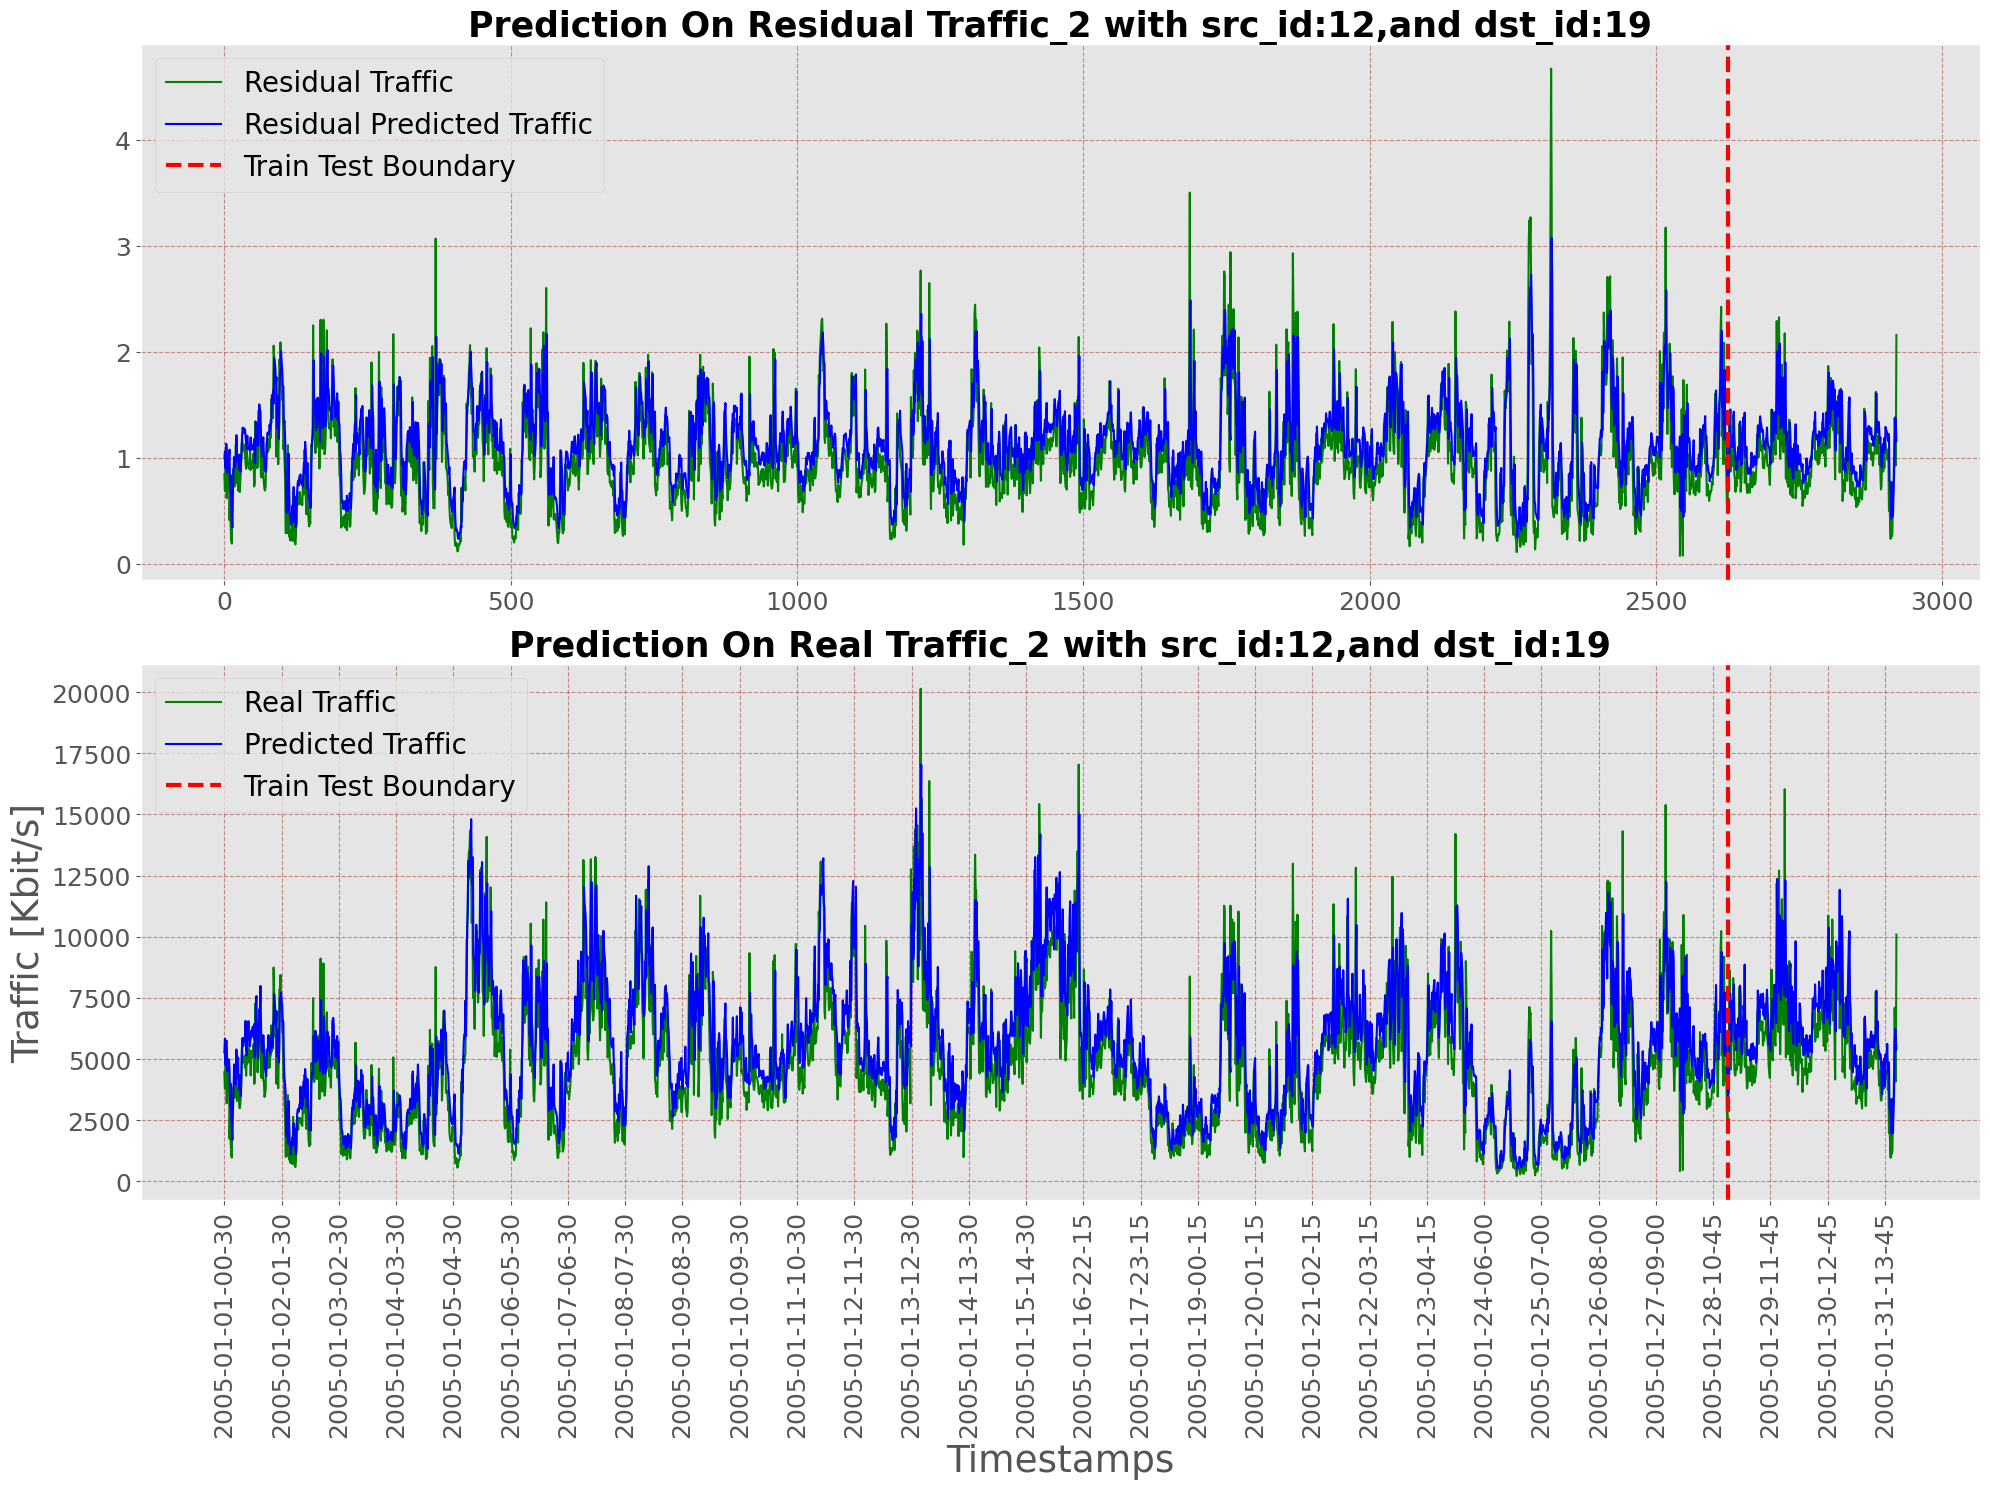

In [ ]:
# Call Function
models_list = [conv_lstm_with_outliers,conv_lstm_with_outliers]
residual_list = [residual_dataframe_with_outliers,residual_dataframe_without_outliers]
seasonal_list = [seasonal_dataframe_with_outliers,seasonal_dataframe_without_outliers]
trend_list = [trend_dataframe_with_outliers, trend_dataframe_without_outliers]
train_part_list = [train_part_dataframe_with_outliers,train_part_dataframe_without_outliers]
test_part_list = [test_part_dataframe_with_outliers,test_part_dataframe_without_outliers]


index = 1
title =f'CONV_LSTM_Prediction_graph_for_traffic_{row}_by_residuals_.png'
plot_results(models_list, residual_list,seasonal_list, trend_list, train_part_list, test_part_list,cleaned_traffic_df,index,title)

In [ ]:
display(rnn_perforamnce_without_outliers_normalized)
display(conv_lstm_performance_without_outliers_normalized)

,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_1: RNN,Prediction_on_residual,with_outliers,37.0,0.202944,0.076440,0.216851
1,2,12.0,19.0,Model_1: Rnn,Prediction_on_residual,without_outliers,34.0,0.209664,0.073936,0.232761
2,2,12.0,19.0,Model_1: Rnn,Prediction_on_residual,normalized_without_outliers,35.0,0.040526,0.003486,0.195460


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE
0,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,with_outliers,27.0,0.231899,0.085471,0.265155
1,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,without_outliers,26.0,0.172280,0.065704,0.170327
2,2,12.0,19.0,Model_2: CONV_LSTM,Prediction_on_residual,normalized_without_outliers,24.0,0.039974,0.003024,0.224843
